<a href="https://colab.research.google.com/github/IpastorSan/GAN_neural_style_transfer/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First try to implement style transfer based on "A neural Algorithm of Artistic Style" https://arxiv.org/pdf/1508.06576.pdf

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19

In [58]:
content_image = "darth_vader_content.jpg"
style_image = "pollock_style.jpg"

In [3]:
result_prefix = "vader_generated" #???

In [59]:
#Weights of the different weight components (leap of faith)
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [60]:
#Dimensions of generated picture
width, height = tf.keras.preprocessing.image.load_img(content_image).size
img_nrows = 400
img_ncols = int(width*img_nrows / height)

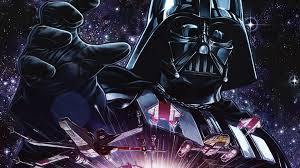

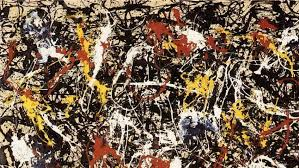

In [6]:
from IPython.display import Image, display
display(Image(content_image))
display(Image(style_image))

In [67]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #The images are converted from RGB to BGR,\
    # then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
    img = vgg19.preprocess_input(img) 
    return tf.convert_to_tensor(img)

In [68]:
content_processed = preprocess_image(content_image)
style_processed = preprocess_image(style_image)

In [70]:
print(f"Content processed shape : {content_processed.shape}\nStyle processed shape {style_processed.shape}")

Content processed shape : (1, 400, 714, 3)
Style processed shape (1, 400, 714, 3)


In [20]:
def unprocess_image(img):
    #Transforms a tensor into a valid image
    img = tf.reshape(img,(img_nrows, img_ncols, 3))
    img = img.numpy()
    #remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

We need a picture here, following the shape transformations of the gram matrix

In [92]:
def gram_matrix(x):
    #input is (1, Height, Width, C) ---> (H,W,C)
    x = tf.squeeze(x)
    x = tf.transpose(x, (2,0,1))   #shape (C,H,W)
    features = tf.reshape(x, (tf.shape(x)[0], -1))  #shape (C, H*W)
    gram = tf.matmul(features, tf.transpose(features)) #dot product of features and trnsposed of features (autocorrelation)
    return gram

In [ ]:
def style_loss(style, combination):
    s = gram_matrix(style)
    c = gram_matrix(combination)
    channels = 3 
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(s-c)) / (4.0 * (channels ** 2) * (size**2)) #Look up this formula

In [ ]:
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(combination - content))

In [ ]:
def total_loss(x):
    a = tf.square(x[:, :img_nrows - 1, :img_ncols -1, :] - x[:, 1:, :img_ncols - 1, :])
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))